# BOT

This file is used to perform real life games against humans

In [1]:
from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPProcessor, CLIPModel

import torch
import matplotlib.pyplot as plt

import os
from PIL import Image
import random

from typing import List

device = "cuda" if torch.cuda.is_available() else "cpu"

C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Each method that makes the bot playable also plot the name of the card (the number). This allow the user who is controlling the bot to collect more data about the card played

In [2]:
class Bot():
    def __init__(self, blip_path_weights: str, clip_path_weights: str, images: List[Image.Image]):
        self.images = images

        self.blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        self.blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16").to(device)
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

        self.blip_model.load_state_dict(torch.load(blip_path_weights))
        self.clip_model.load_state_dict(torch.load(clip_path_weights))

        self.blip_model.eval()
        self.clip_model.eval()

        self.cards_in_hand = dict()

    def draw_initial_hand(self, card_names: str) -> None:
        card_names = card_names.split()

        self.cards_in_hand = {name: card for name, card in self.images.items() if name in card_names}

    def get_cards_in_hand(self) -> None:
        for _, card in self.cards_in_hand.items():
            plt.imshow(card)
            plt.show()

    def remove_card(self, card_name: str) -> None:
        self.cards_in_hand.pop(card_name, None)

    def add_card(self, card_name: str) -> None:
        self.cards_in_hand[card_name] = self.images[card_name]

    def get_caption(self) -> str:
        name, image = random.choice([(k,v) for k,v in self.cards_in_hand.items()])
        inputs = self.blip_processor(image, return_tensors="pt").to("cuda")

        with torch.no_grad():
            caption_ids = self.blip_model.generate(
                **inputs,
                max_length=50,  
                num_return_sequences=1,
                do_sample=True,  
                top_k=50,        
                top_p=0.95,      
                temperature=0.7, 
                repetition_penalty=1.2, 
                no_repeat_ngram_size=3 
            )

        caption = self.blip_processor.decode(caption_ids[0], skip_special_tokens=True)

        plt.imshow(image)
        plt.title(caption + "\n" + name)
        plt.show()

        self.remove_card(name)

        return caption

    def vote_card(self, images_names_on_table: str, caption: str) -> None:
        images_names_on_table = images_names_on_table.split()
        images_on_table = [self.images[name] for name in images_names_on_table]

        inputs = self.clip_processor(text=caption, images=images_on_table, return_tensors="pt", padding="max_length", truncation=True).to(device)

        with torch.no_grad():
            outputs = self.clip_model(**inputs)
        
        logits_per_image = outputs.logits_per_image

        probs_per_image = logits_per_image.softmax(dim=0).squeeze()
        max_score_idx = torch.argmax(probs_per_image).item()

        chosen_image = images_on_table[max_score_idx]
        image_name = images_names_on_table[max_score_idx]
        
        plt.imshow(chosen_image)
        plt.title(image_name)
        plt.show()

    def choose_card(self, caption: str) -> None:
        inputs = self.clip_processor(text=caption, images=list(self.cards_in_hand.values()), return_tensors="pt", padding="max_length", truncation=True).to(device)

        with torch.no_grad():
            outputs = self.clip_model(**inputs)
        
        logits_per_image = outputs.logits_per_image

        probs_per_image = logits_per_image.softmax(dim=0).squeeze()
        max_score_idx = torch.argmax(probs_per_image).item()

        chosen_image = list(self.cards_in_hand.values())[max_score_idx]
        chosen_image_name = list(self.cards_in_hand.keys())[max_score_idx]
        
        plt.imshow(chosen_image)
        plt.title(chosen_image_name)
        plt.show()

        self.remove_card(chosen_image_name)

In [3]:
def get_cards(path):
    images = dict()
    for image in os.listdir(path):
        raw_image = Image.open(os.path.join(path, image)).convert("RGB")
        raw_image = raw_image.resize((224,224))
        images[image.split(".")[0]] = raw_image

    return images

In [4]:
images = get_cards("../cards/odissey_cards")

bot = Bot("../weights/rephrased_blip(2nd)/epoch50.pt", "../weights/rephrased_coco_clip(2nd)/epoch13.pt", images)

C:\Users\stefa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Note

All the methods here accepts just the images numbers. If a list of them is required (for example when the bot has to vote the cards on the table or when it has to draw the initial hand) then the methods expect it to be a string of space separated images number.

In [5]:
bot.draw_initial_hand("3 30 4 35 55 43")

In [65]:
bot.add_card("9")

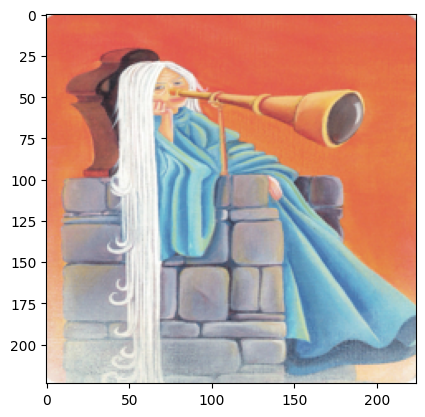

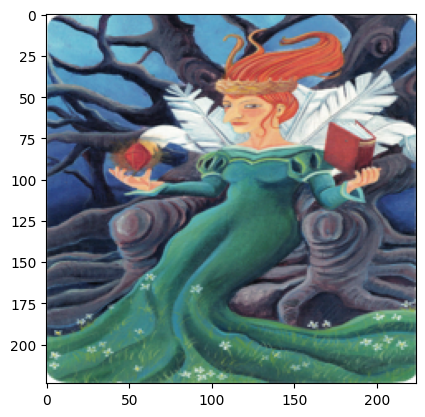

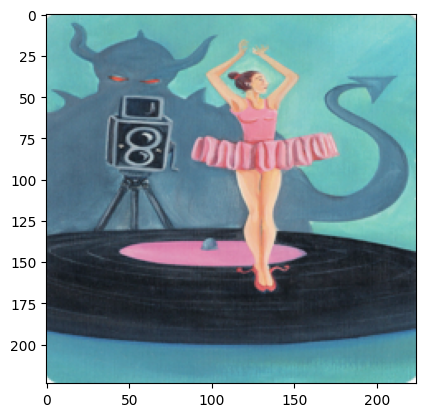

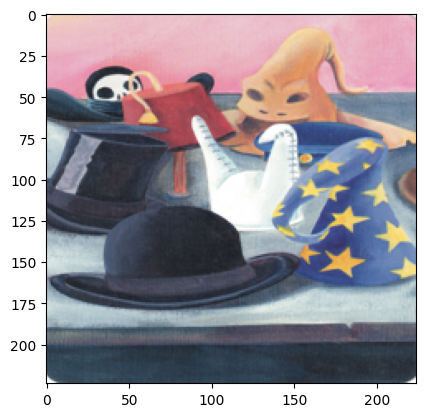

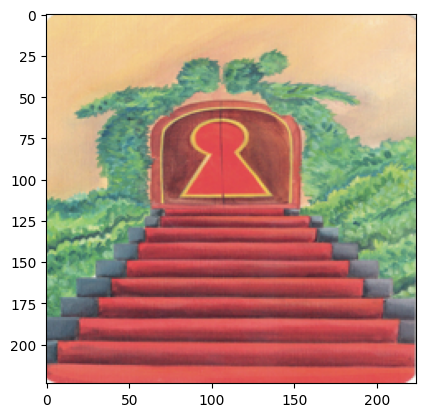

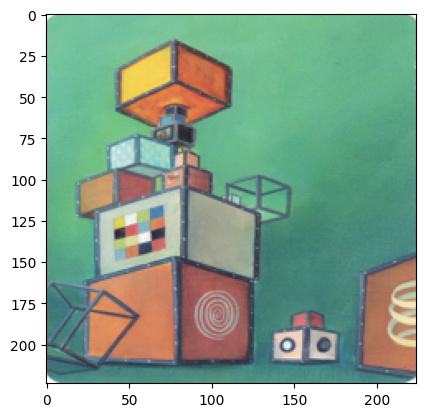

In [66]:
bot.get_cards_in_hand()

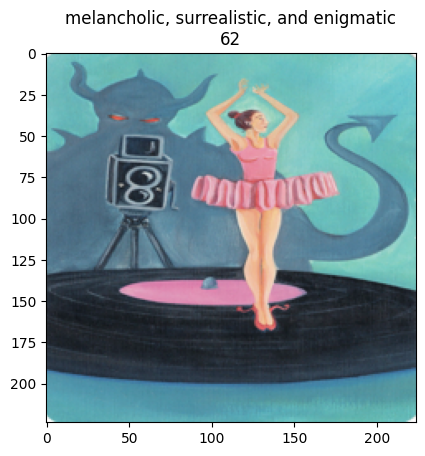

melancholic, surrealistic, and enigmatic


In [67]:
caption = bot.get_caption()
print(caption)

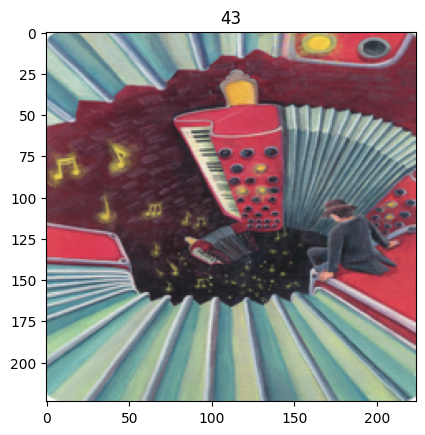

In [62]:
bot.choose_card("Poor art.")

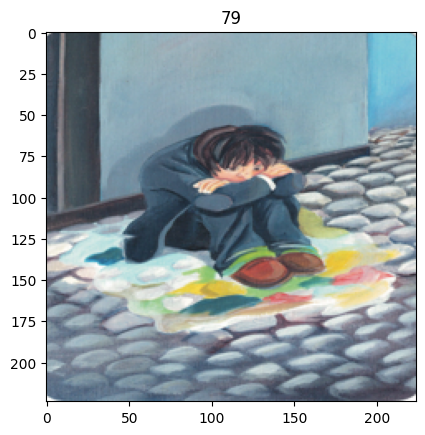

In [64]:
bot.vote_card("79 7 60", "Poor art.")